### Гипотеза

Посмотреть как то влияет ли средний чек или стандартное отклонение в рамках клиента на то уйдет ли он от БК или нет. Также посмотрим количество позиций в рамках одного чека.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.prompt { min-width:10ex !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.float_format', lambda x: '%.6f' % x) 

/tmp/ipykernel_88075/437858164.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output
/tmp/ipykernel_88075/437858164.py:1: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output


In [3]:
df_train = pd.read_parquet('../data/train_dataset_hackaton2023_train.gzip')

In [4]:
ids_cols = ['customer_id', 'buy_post', 'startdatetime']

In [5]:
df_train.describe()

,customer_id,date_diff_post,buy_post,revenue,startdatetime,ownareaall_sqm
count,12129384.000000,9660867.000000,12129384.000000,12129384.000000,12129384,12129384.000000
mean,19809542.263361,20.480386,0.796485,106.799476,2023-02-20 12:19:13.394691,215.513003
min,29891.000000,0.000000,0.000000,0.010000,2022-09-02 00:00:39,0.000000
25%,10108525.000000,8.000000,1.000000,44.990000,2022-12-06 16:12:06,104.900000
50%,21274586.000000,17.000000,1.000000,79.980000,2023-02-22 11:04:22,210.400000
75%,28038562.000000,30.000000,1.000000,131.772500,2023-05-09 18:48:02,300.000000
max,46661804.000000,60.000000,1.000000,14499.710000,2023-08-01 23:57:46,978.700000
std,11389040.436254,15.270910,0.402613,107.438512,NaN,122.590689


Схлопнуть до одного чека для каждого клиента

In [6]:
df_sum_agg = df_train.groupby(ids_cols, as_index=True).agg({"revenue": ["sum", "count"]})
df_sum_agg.columns = ["revenue_sum", "items_count"]
df_sum_agg.reset_index(inplace=True)

Отличаются ли показатели

In [8]:
df_sum_agg.groupby(['buy_post']).agg({"revenue_sum": ['mean', 'std', 'median'], "items_count": ['mean', 'std', 'median']})

revenue_sum                       items_count                  
                mean        std     median        mean      std   median
buy_post                                                                
0         476.078889 415.020007 369.970000    4.199351 3.136758 3.000000
1         442.942163 384.255000 344.970000    4.213654 3.155191 3.000000

Похоже, что можно отсеить людей, у которых чеки были 

In [9]:
df_sum_agg.describe(percentiles=[i / 10 for i in range(1, 11)] + [0.95, 0.97, 0.99])

,customer_id,buy_post,startdatetime,revenue_sum,items_count
count,2880586.000000,2880586.000000,2880586,2880586.000000,2880586.000000
mean,20175589.458162,0.795933,2023-02-19 14:53:17.099490,449.704280,4.210735
min,29891.000000,0.000000,2022-09-02 00:00:39,1.000000,1.000000
10%,3967570.000000,0.000000,2022-10-18 15:34:09,84.980000,1.000000
20%,8610663.000000,0.000000,2022-11-19 13:43:27,150.980000,1.000000
30%,12006129.000000,1.000000,2022-12-22 14:30:48.500000,239.990000,2.000000
40%,18257146.000000,1.000000,2023-01-21 19:03:23,291.970000,3.000000
50%,21647330.000000,1.000000,2023-02-21 16:42:07.500000,349.980000,3.000000
60%,24001496.000000,1.000000,2023-03-24 12:08:46,419.970000,4.000000
70%,26844698.000000,1.000000,2023-04-22 17:00:46,520.970000,6.000000


Как будто можно убрать их из анализа и построения?)

In [22]:
df_sum_agg[df_sum_agg["revenue_sum"] >= 2000].groupby(['buy_post']).agg({"revenue_sum": ['mean', 'std', 'median']})

revenue_sum                       
                mean        std      median
buy_post                                   
0        2559.717927 763.531571 2344.805000
1        2523.811224 688.754792 2327.910000

In [10]:
import plotly.io as pio

pio.renderers
pio.renderers.default = "png"

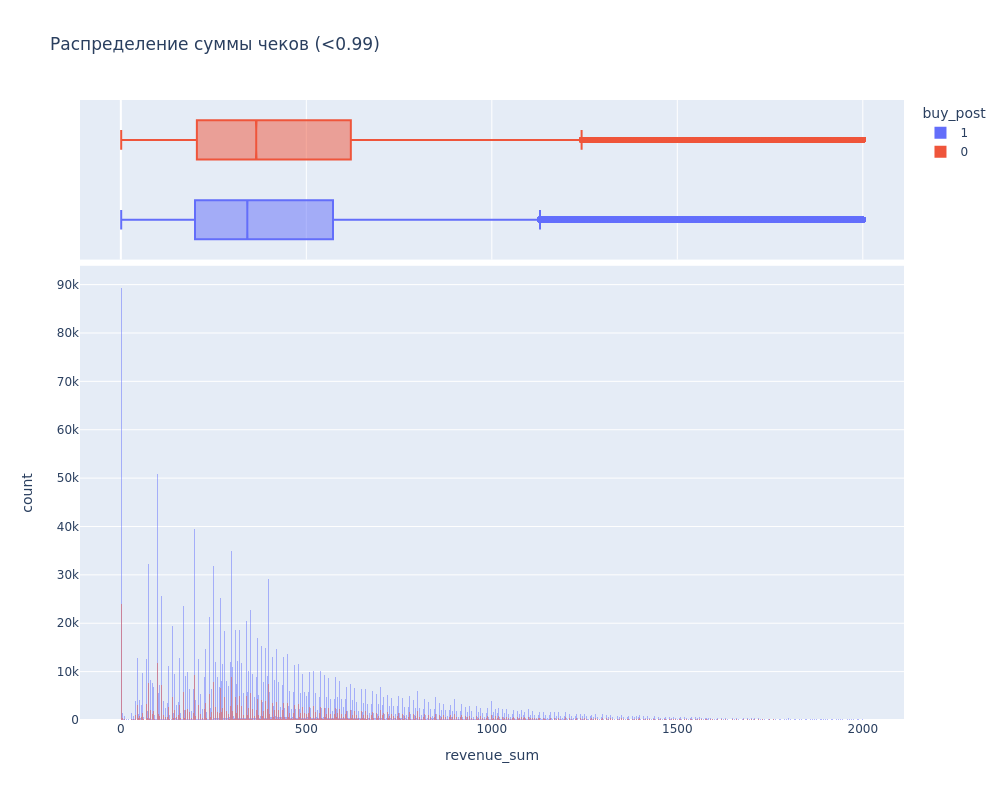

In [30]:
fig = px.histogram(
    df_sum_agg[df_sum_agg["revenue_sum"] < 2000],
    x="revenue_sum", 
    color="buy_post", 
    marginal="box",
    width=1000,
    height=800,
    title="Распределение суммы чеков (<0.99)",
    barmode='overlay',
)
fig.show()

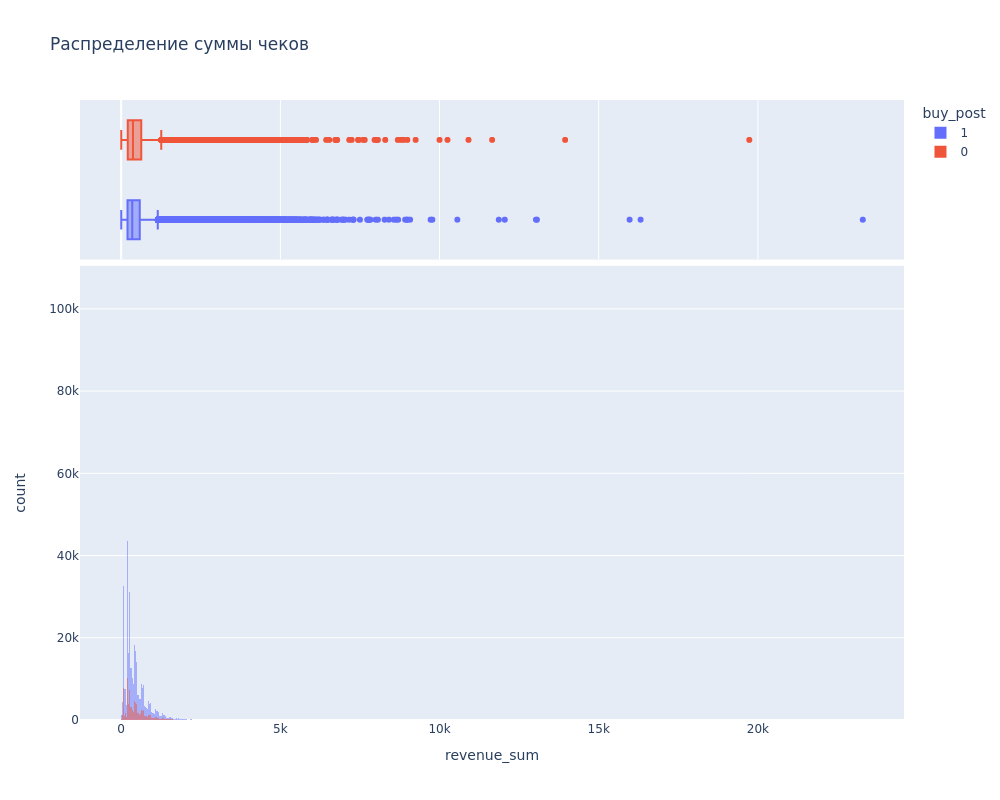

In [31]:
fig = px.histogram(
    df_sum_agg,
    x="revenue_sum", 
    color="buy_post", 
    marginal="box",
    width=1000,
    height=800,
    title="Распределение суммы чеков",
    barmode='overlay',
)
fig.show()

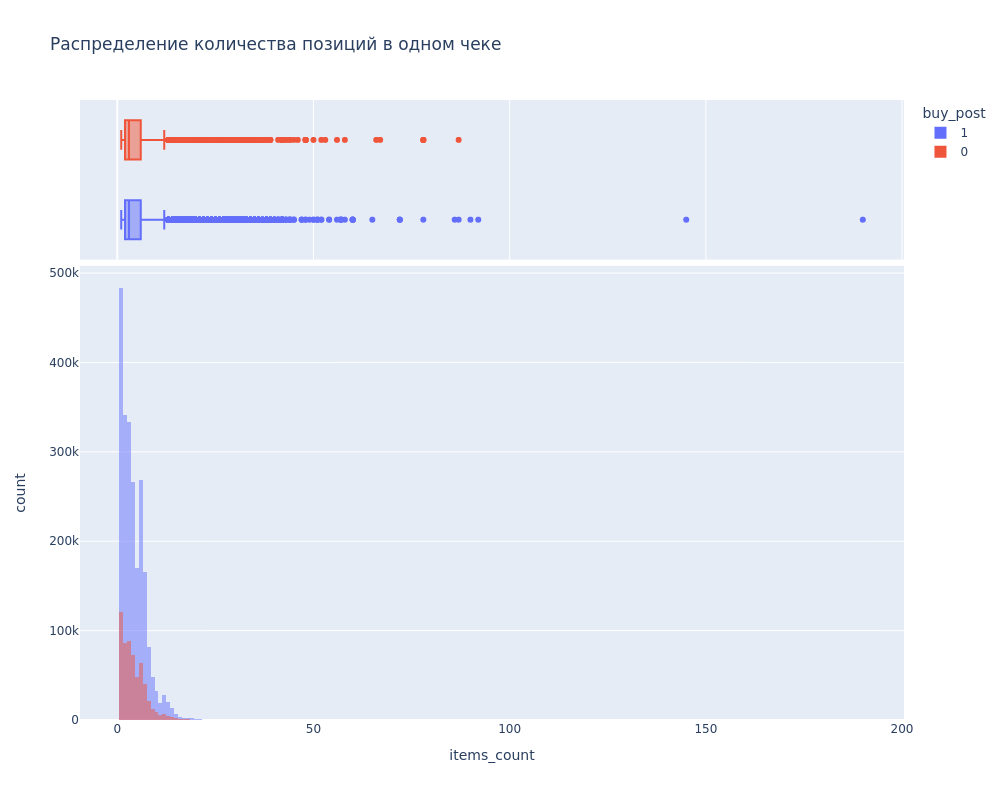

In [11]:
fig = px.histogram(
    df_sum_agg,
    x="items_count", 
    color="buy_post", 
    marginal="box",
    width=1000,
    height=800,
    title="Распределение количества позиций в одном чеке",
    barmode='overlay',
)
fig.show()

Попробуем схлопнуть до одного клиента

In [12]:
df_by_customer_data = (
    df_sum_agg
    .groupby(['customer_id', 'buy_post'])
    .agg({
        "revenue_sum": ['mean', 'std', 'count'],
        "items_count": ['mean', 'std'],
    }).reset_index()
)
df_by_customer_data.columns = [
    'customer_id',
    'buy_post',
    'revenue_mean', 
    'revenue_std',
    'revenue_count', 
    'items_mean',
    'items_std',
]

In [13]:
(
    df_by_customer_data
    .groupby(['buy_post'])
    .agg({
        "revenue_mean": ['mean', 'std'], 
        "revenue_std": ['mean', 'std'], 
        'revenue_count': ["mean", "std"],
        'items_mean': ["mean", "std"],
        'items_std': ["mean", "std"],
    })
)

revenue_mean            revenue_std            revenue_count  \
                 mean        std        mean        std          mean   
buy_post                                                                
0          495.035979 302.256174  267.976646 226.410171      4.171839   
1          491.021468 292.755836  255.679169 200.997945      6.384809   

                  items_mean          items_std           
              std       mean      std      mean      std  
buy_post                                                  
0        2.364479   4.280420 2.161176  2.152960 1.640313  
1        5.660218   4.474980 2.211653  2.190080 1.559377

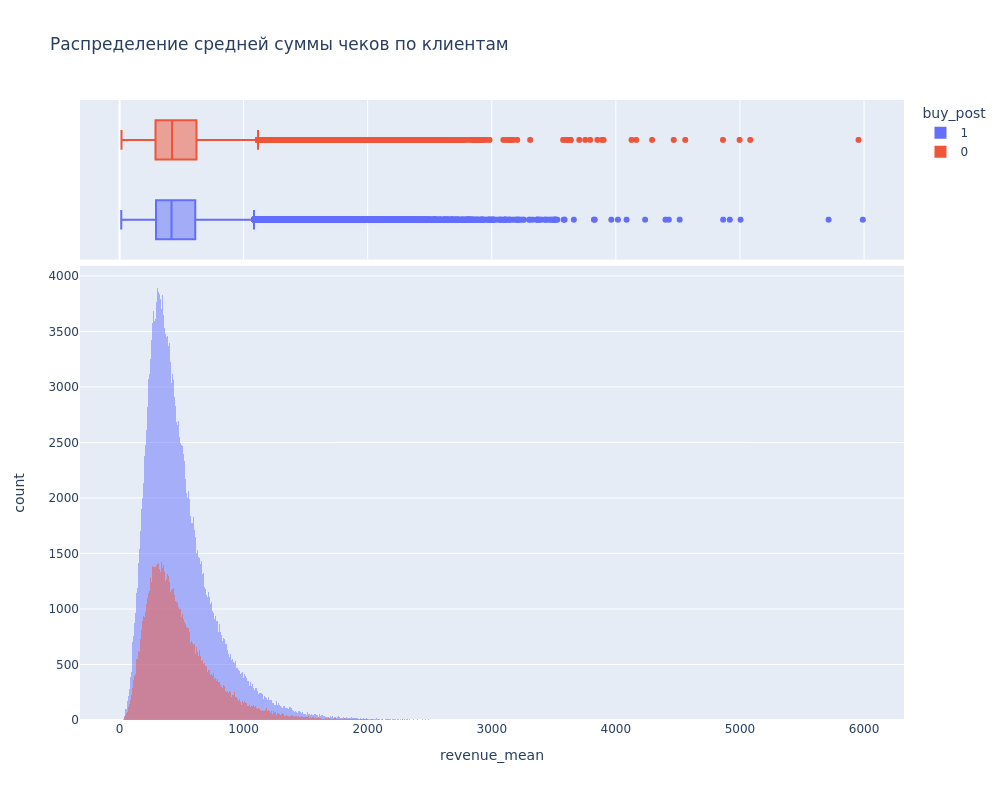

In [38]:
fig = px.histogram(
    df_by_customer_data,
    x="revenue_mean", 
    color="buy_post", 
    marginal="box",
    width=1000,
    height=800,
    title="Распределение средней суммы чеков по клиентам",
    barmode='overlay',
)
fig.show()

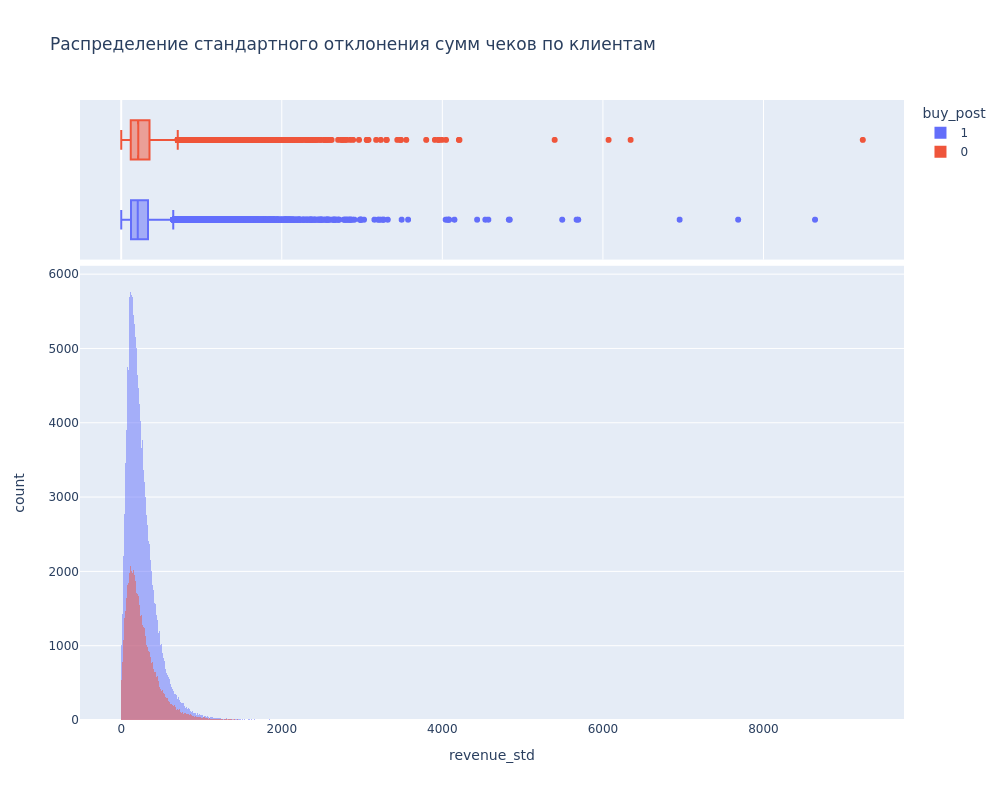

In [39]:
fig = px.histogram(
    df_by_customer_data,
    x="revenue_std", 
    color="buy_post", 
    marginal="box",
    width=1000,
    height=800,
    title="Распределение стандартного отклонения сумм чеков по клиентам",
    barmode='overlay',
)
fig.show()

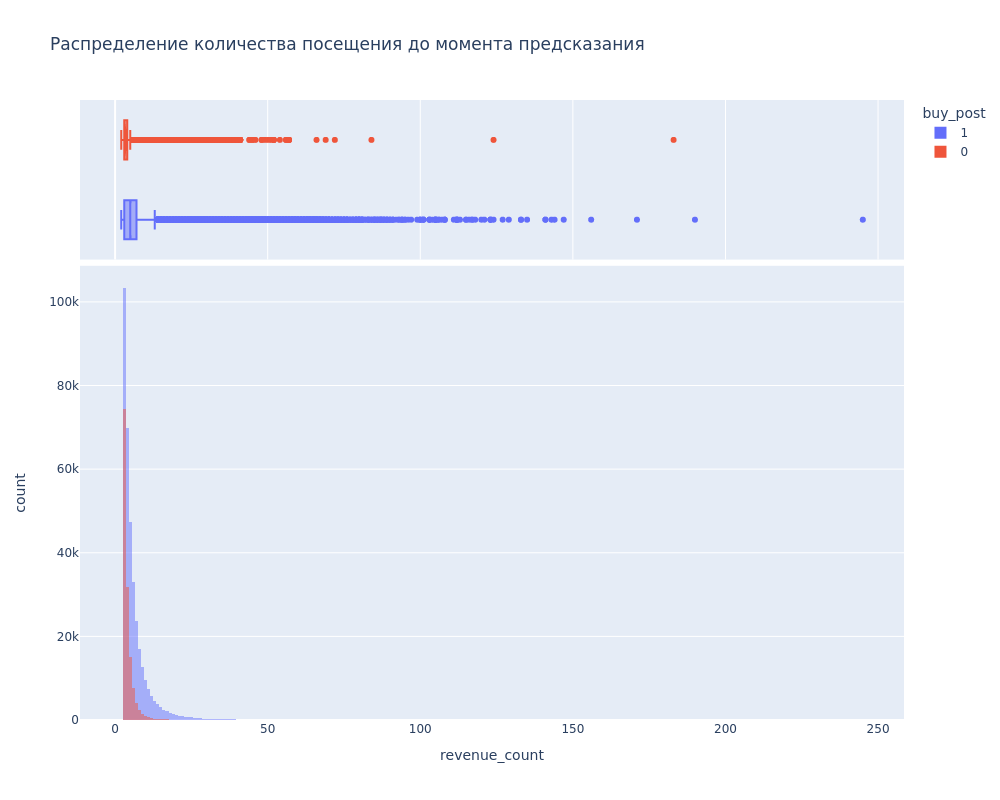

In [40]:
fig = px.histogram(
    df_by_customer_data,
    x="revenue_count", 
    color="buy_post", 
    marginal="box",
    width=1000,
    height=800,
    title="Распределение количества посещения до момента предсказания",
    barmode='overlay',
)
fig.show()

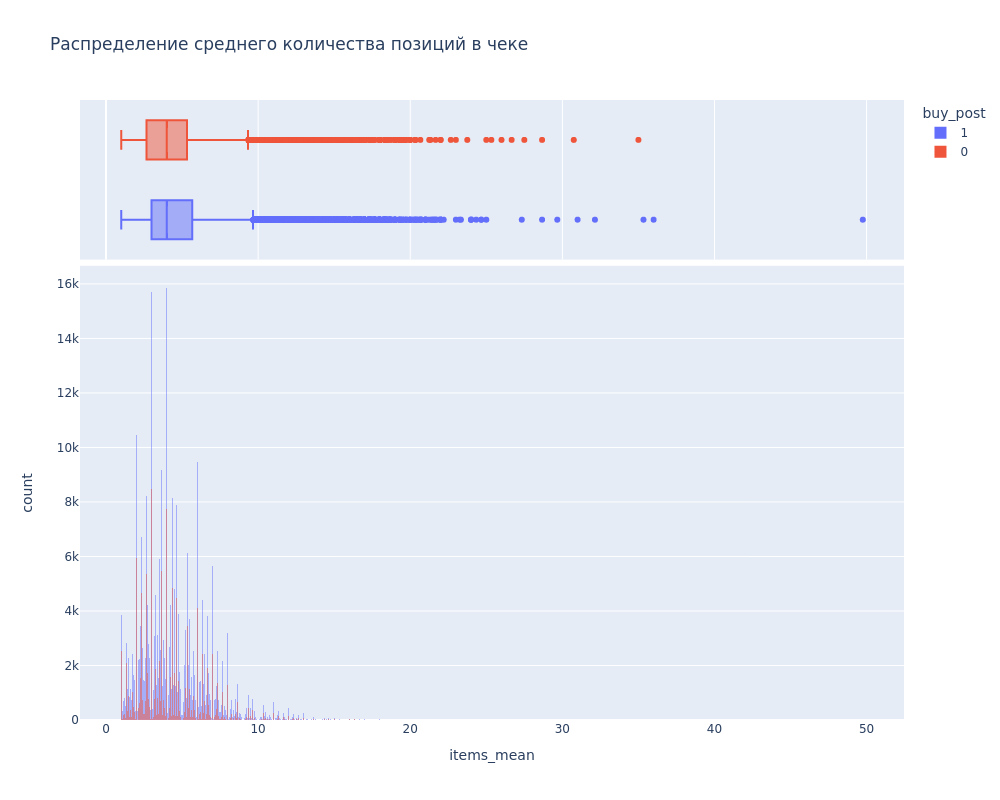

In [14]:
fig = px.histogram(
    df_by_customer_data,
    x="items_mean", 
    color="buy_post", 
    marginal="box",
    width=1000,
    height=800,
    title="Распределение среднего количества позиций в чеке",
    barmode='overlay',
)
fig.show()

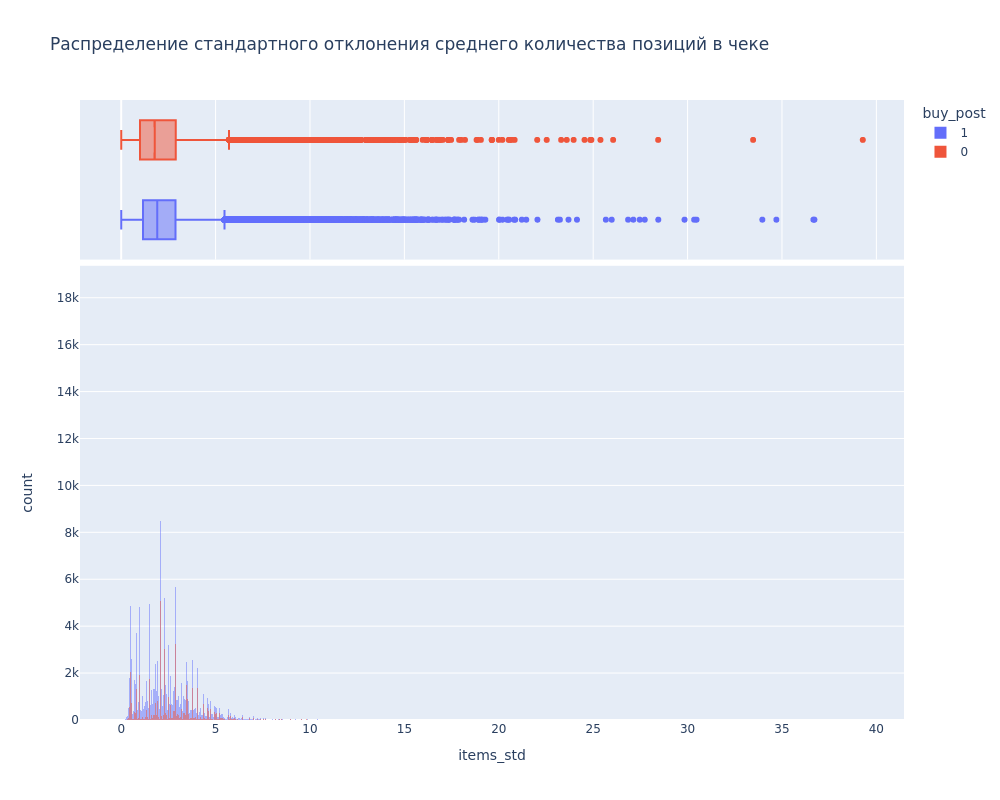

In [16]:
fig = px.histogram(
    df_by_customer_data[df_by_customer_data["items_std"] < 40],
    x="items_std", 
    color="buy_post", 
    marginal="box",
    width=1000,
    height=800,
    title="Распределение стандартного отклонения среднего количества позиций в чеке",
    barmode='overlay',
)
fig.show()

In [17]:
df_by_customer_data.describe(percentiles=[i / 10 for i in range(1, 11)] + [0.95, 0.97, 0.99])

,customer_id,buy_post,revenue_mean,revenue_std,revenue_count,items_mean,items_std
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,20246346.095608,0.718190,492.152797,259.144721,5.761172,4.420151,2.179619
std,11496610.350691,0.449882,295.469257,208.546239,5.057282,2.199285,1.582691
min,29891.000000,0.000000,13.497500,0.000000,2.000000,1.000000,0.000000
10%,4015495.600000,0.000000,208.984000,68.062961,3.000000,2.000000,0.577350
20%,8634336.400000,0.000000,267.719500,105.417059,3.000000,2.666667,1.000000
30%,12046489.400000,1.000000,316.730000,137.827016,3.000000,3.000000,1.224745
40%,18298842.800000,1.000000,365.968333,170.962765,4.000000,3.600000,1.527525
50%,21725643.000000,1.000000,419.995833,207.891439,4.000000,4.000000,1.892969
60%,24118279.600000,1.000000,483.315000,251.484659,5.000000,4.600000,2.217356
